- taguear manuamente turn e segmentos da votla (reta, subida, curva dos patos)
- gerar o reports
- algoritmo de inferencia de turns

In [1]:
import json
import pandas as pd
import numpy as np
import scipy as sp
import datetime
from scipy import stats
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 3000)

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data Acquisition & Transformation

In [2]:
tracks = pd.read_excel('./track_27_data.xlsx')

# Data Transformation
tracks['delta_time'] = tracks.created_at_local.diff()
tracks['segundos'] = tracks.delta_time.apply(lambda x: x.total_seconds())
tracks['delta_speed'] = tracks.speed.diff()
tracks['aceleração'] = tracks.delta_speed/tracks.segundos
tracks['km_h'] = tracks.speed * 3.6 

tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29166 entries, 0 to 29165
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   track_id          29166 non-null  int64          
 1   id                29166 non-null  int64          
 2   turn              29166 non-null  int64          
 3   ignored           29166 non-null  bool           
 4   created_at_local  29166 non-null  datetime64[ns] 
 5   latitude          29166 non-null  float64        
 6   longitude         29166 non-null  float64        
 7   latLongAccuracy   29166 non-null  float64        
 8   heading           28787 non-null  float64        
 9   speed             29129 non-null  float64        
 10  delta_time        29165 non-null  timedelta64[ns]
 11  segundos          29165 non-null  float64        
 12  delta_speed       29114 non-null  float64        
 13  aceleração        29094 non-null  float64        
 14  km_h  

In [3]:
tracks.head(10)

track_id  id  turn  ignored        created_at_local   latitude  longitude  \
0        11   1     1     True 2024-06-22 00:52:03.684 -23.240641 -45.911713   
1        11   2     1     True 2024-06-22 00:52:05.374 -23.241007 -45.912003   
2        11   3     1     True 2024-06-22 00:52:08.882 -23.241007 -45.912003   
3        11   4     1     True 2024-06-22 00:52:11.985 -23.240826 -45.911894   
4        11   5     1     True 2024-06-22 00:52:12.927 -23.240818 -45.911905   
5        11   6     1     True 2024-06-22 00:52:13.970 -23.240816 -45.911916   
6        11   7     1     True 2024-06-22 00:52:14.962 -23.240828 -45.911928   
7        11   8     1     True 2024-06-22 00:52:15.966 -23.240829 -45.911941   
8        11   9     1     True 2024-06-22 00:52:16.965 -23.240835 -45.911943   
9        11  10     1     True 2024-06-22 00:52:17.973 -23.240822 -45.911912   

   latLongAccuracy     heading     speed             delta_time  segundos  \
0       100.000000         NaN       NaN                    NaT       NaN   
1        27.683001         NaN       NaN 0 days 00:00:01.690000     1.690   
2        27.683001         NaN  0.000000 0 days 00:00:03.508000     3.508   
3         7.800000   29.156851  2.799020 0 days 00:00:03.103000     3.103   
4         7.750000  328.975006  1.420343 0 days 00:00:00.942000     0.942   
5         7.700000  300.885956  1.134659 0 days 00:00:01.043000     1.043   
6         7.650000  244.277695  1.223610 0 days 00:00:00.992000     0.992   
7         7.600000  257.245544  1.283105 0 days 00:00:01.004000     1.004   
8         7.533000  231.861740  0.797063 0 days 00:00:00.999000     0.999   
9         7.400000   68.489685  1.640237 0 days 00:00:01.008000     1.008   

   delta_speed  aceleração       km_h  
0          NaN         NaN        NaN  
1          NaN         NaN        NaN  
2          NaN         NaN   0.000000  
3     2.799020    0.902037  10.076471  
4    -1.378676   -1.463563   5.113236  
5    -0.285685   -0.273907   4.084772  
6     0.088951    0.089669   4.404997  
7     0.059495    0.059258   4.619178  
8    -0.486042   -0.486529   2.869426  
9     0.843174    0.836482   5.904853

In [4]:
tracks.track_id.unique()

array([11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27],
      dtype=int64)

In [5]:
tracks.created_at_local.min()

Timestamp('2024-06-22 00:52:03.684000')

In [6]:
tracks.created_at_local.max()

Timestamp('2024-08-17 14:06:14.058000')

In [7]:
tracks.groupby('track_id')[['id','turn']].nunique()

id  turn
track_id            
11         229     1
12        2082     3
13        4791     5
14         834     1
15         330     3
17        1784     2
18        2425     1
19          57     1
20         171     1
21         606     3
22        1921     5
23        2634     3
24        7352     5
26        1905     1
27        2045     1

In [8]:
tracks.groupby('track_id')[['latitude','longitude']].mean()

latitude  longitude
track_id                      
11       -23.240892 -45.911945
12       -23.244216 -45.909658
13       -23.245000 -45.910306
14       -23.549882 -46.677028
15       -23.533145 -46.669103
17       -23.530876 -46.669803
18       -23.530620 -46.669791
19       -23.533459 -46.668942
20       -23.530833 -46.668771
21       -23.530826 -46.669904
22       -23.531359 -46.669536
23       -23.244027 -45.909670
24       -23.244325 -45.909901
26       -23.243836 -45.909605
27       -23.531032 -46.669591

In [9]:
df = tracks.loc[tracks.track_id==27]

# Insigths

In [10]:
df.km_h.mean()

8.537601851490676

1h -> 60min -> 3600sec

In [11]:
def calculate_duration(speed_in_kmh, distance_in_km=1):
    speed_in_ms = speed_in_kmh / 3.6
    distance_in_m = distance_in_km * 1000
    duration_in_s = distance_in_m / speed_in_ms
    return datetime.timedelta(seconds=duration_in_s)

In [12]:
# Distancia
vm = df.speed.mean()
delta_T = df.created_at_local.max() - df.created_at_local.min()
distancia = vm * delta_T.total_seconds()
pace = calculate_duration(df.km_h.mean())
print(f'''
- pace: {pace}
- Velocidade média:{round(vm,2)} m/s,
- Tempo total:{round(delta_T.total_seconds()/3600, 2)} h,
- Distância: {round(distancia,2)} m
- Voltas: {df.turn.unique()}
'''
     )


- pace: 0:07:01.664076
- Velocidade média:2.37 m/s,
- Tempo total:0.56 h,
- Distância: 4753.23 m
- Voltas: [1]



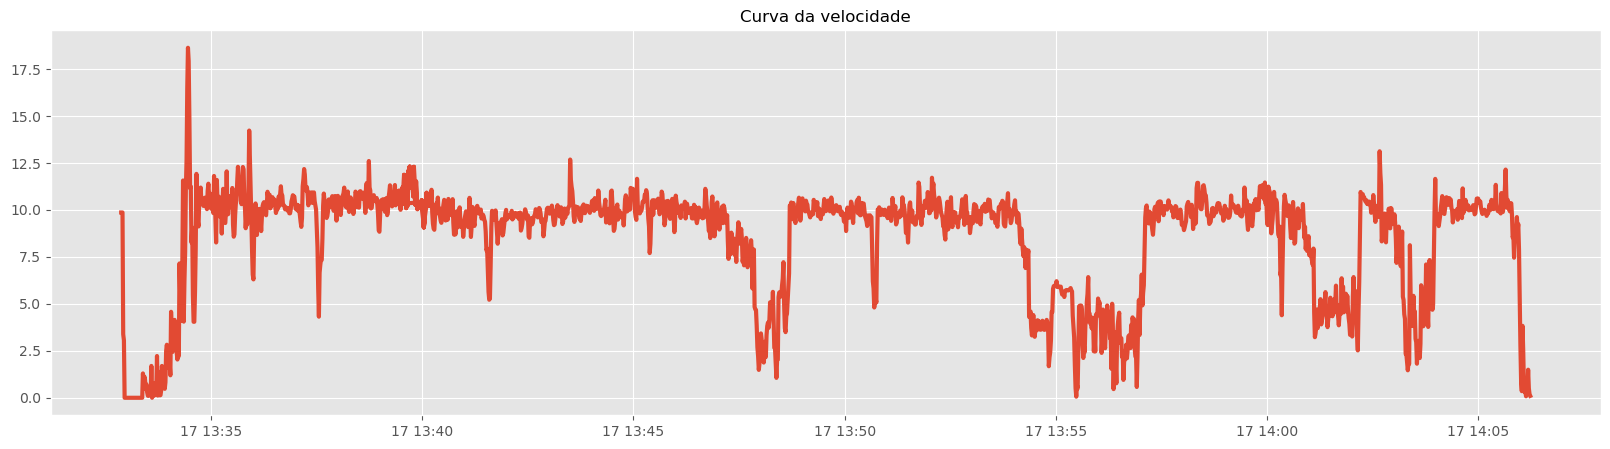

In [13]:
## plot data
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(df.created_at_local, df.km_h)
plt.title('Curva da velocidade') 
plt.show()

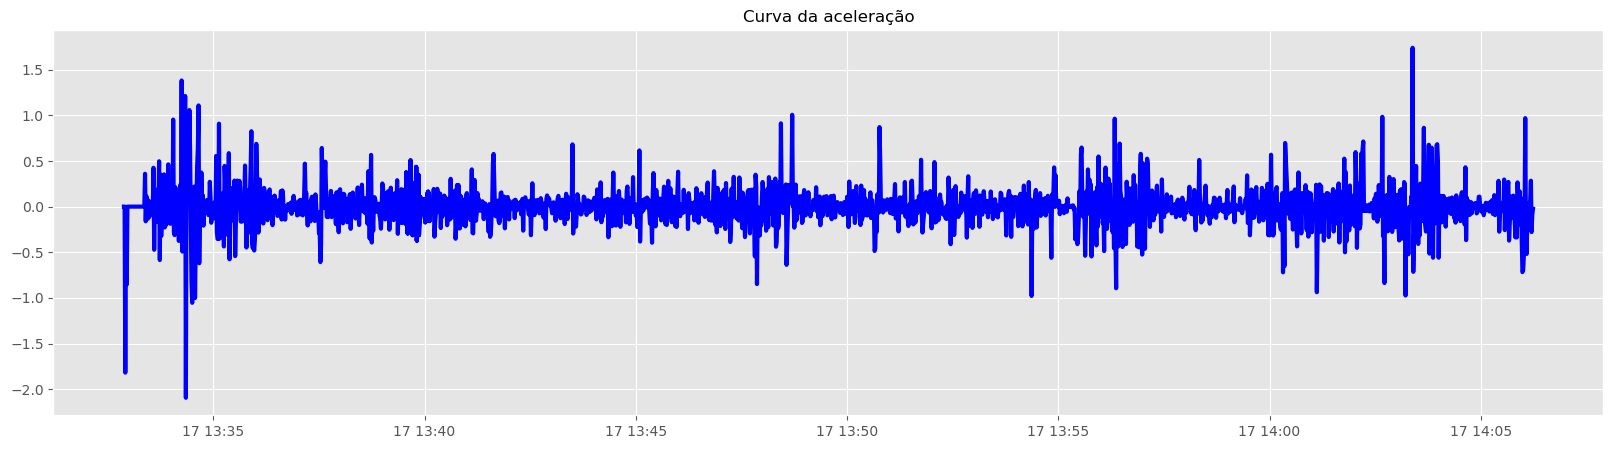

In [14]:
## plot data
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(df.created_at_local, df.aceleração, color='b')
plt.title('Curva da aceleração') 
plt.show()

Text(0.5, 1.0, 'Curva da turn')

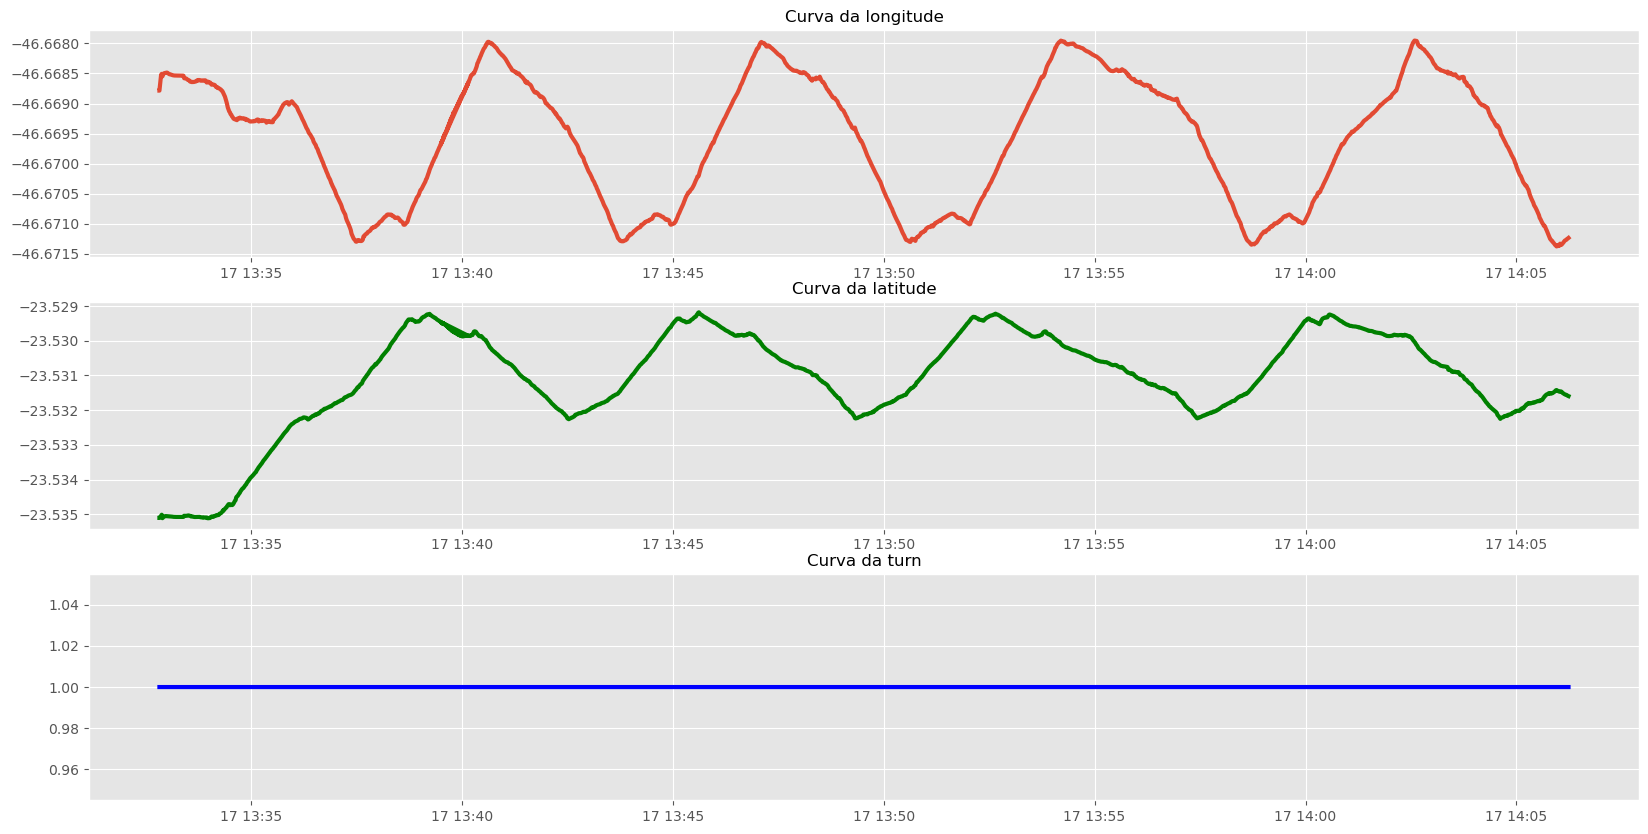

In [15]:
## plot data
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(df.created_at_local, df.longitude)
ax[0].set_title('Curva da longitude') 

ax[1].plot(df.created_at_local, df.latitude,color='g')
ax[1].set_title('Curva da latitude') 

ax[2].plot(df.created_at_local, df.turn, color='b')
ax[2].set_title('Curva da turn')

In [16]:
columns = ['created_at_local', 'turn', 'latitude', 'longitude']

df.filter(columns).head(3000)

created_at_local  turn   latitude  longitude
27121 2024-08-17 13:32:49.792     1 -23.535104 -46.668785
27122 2024-08-17 13:32:49.800     1 -23.535104 -46.668785
27123 2024-08-17 13:32:52.150     1 -23.535043 -46.668524
27124 2024-08-17 13:32:53.076     1 -23.535012 -46.668506
27125 2024-08-17 13:32:54.038     1 -23.535111 -46.668548
27126 2024-08-17 13:32:55.028     1 -23.535092 -46.668515
27127 2024-08-17 13:32:56.047     1 -23.535069 -46.668499
27128 2024-08-17 13:32:57.041     1 -23.535059 -46.668494
27129 2024-08-17 13:32:58.032     1 -23.535053 -46.668492
27130 2024-08-17 13:32:59.041     1 -23.535052 -46.668489
27131 2024-08-17 13:33:00.034     1 -23.535053 -46.668485
27132 2024-08-17 13:33:01.040     1 -23.535053 -46.668487
27133 2024-08-17 13:33:02.038     1 -23.535057 -46.668497
27134 2024-08-17 13:33:03.101     1 -23.535058 -46.668506
27135 2024-08-17 13:33:04.035     1 -23.535058 -46.668514
27136 2024-08-17 13:33:05.072     1 -23.535058 -46.668514
27137 2024-08-17 13:33:06.051     1 -23.535059 -46.668519
27138 2024-08-17 13:33:07.033     1 -23.535060 -46.668522
27139 2024-08-17 13:33:08.033     1 -23.535067 -46.668526
27140 2024-08-17 13:33:09.033     1 -23.535070 -46.668530
27141 2024-08-17 13:33:10.031     1 -23.535073 -46.668532
27142 2024-08-17 13:33:11.032     1 -23.535074 -46.668533
27143 2024-08-17 13:33:12.029     1 -23.535075 -46.668534
27144 2024-08-17 13:33:13.043     1 -23.535075 -46.668535
27145 2024-08-17 13:33:14.041     1 -23.535076 -46.668535
27146 2024-08-17 13:33:15.035     1 -23.535076 -46.668535
27147 2024-08-17 13:33:16.036     1 -23.535076 -46.668535
27148 2024-08-17 13:33:17.038     1 -23.535075 -46.668535
27149 2024-08-17 13:33:18.050     1 -23.535075 -46.668535
27150 2024-08-17 13:33:19.038     1 -23.535075 -46.668535
27151 2024-08-17 13:33:20.046     1 -23.535075 -46.668535
27152 2024-08-17 13:33:21.037     1 -23.535076 -46.668536
27153 2024-08-17 13:33:22.040     1 -23.535078 -46.668537
27154 2024-08-17 13:33:23.041     1 -23.535075 -46.668536
27155 2024-08-17 13:33:24.036     1 -23.535074 -46.668538
27156 2024-08-17 13:33:25.046     1 -23.535041 -46.668580
27157 2024-08-17 13:33:26.043     1 -23.535046 -46.668581
27158 2024-08-17 13:33:27.042     1 -23.535045 -46.668582
27159 2024-08-17 13:33:28.040     1 -23.535045 -46.668585
27160 2024-08-17 13:33:29.046     1 -23.535041 -46.668596
27161 2024-08-17 13:33:30.046     1 -23.535035 -46.668606
27162 2024-08-17 13:33:31.044     1 -23.535031 -46.668611
27163 2024-08-17 13:33:32.040     1 -23.535038 -46.668614
27164 2024-08-17 13:33:33.053     1 -23.535042 -46.668631
27165 2024-08-17 13:33:34.048     1 -23.535050 -46.668638
27166 2024-08-17 13:33:35.041     1 -23.535064 -46.668637
27167 2024-08-17 13:33:36.037     1 -23.535060 -46.668643
27168 2024-08-17 13:33:37.054     1 -23.535063 -46.668641
27169 2024-08-17 13:33:38.044     1 -23.535073 -46.668642
27170 2024-08-17 13:33:39.040     1 -23.535073 -46.668641
27171 2024-08-17 13:33:40.044     1 -23.535078 -46.668637
27172 2024-08-17 13:33:41.038     1 -23.535078 -46.668632
27173 2024-08-17 13:33:42.055     1 -23.535076 -46.668631
27174 2024-08-17 13:33:43.045     1 -23.535075 -46.668617
27175 2024-08-17 13:33:44.044     1 -23.535074 -46.668620
27176 2024-08-17 13:33:45.045     1 -23.535072 -46.668610
27177 2024-08-17 13:33:46.050     1 -23.535075 -46.668608
27178 2024-08-17 13:33:47.042     1 -23.535074 -46.668611
27179 2024-08-17 13:33:48.035     1 -23.535084 -46.668617
27180 2024-08-17 13:33:49.040     1 -23.535087 -46.668621
27181 2024-08-17 13:33:50.045     1 -23.535089 -46.668616
27182 2024-08-17 13:33:51.042     1 -23.535089 -46.668617
27183 2024-08-17 13:33:52.039     1 -23.535098 -46.668615
27184 2024-08-17 13:33:53.041     1 -23.535091 -46.668621
27185 2024-08-17 13:33:54.048     1 -23.535091 -46.668620
27186 2024-08-17 13:33:55.037     1 -23.535092 -46.668614
27187 2024-08-17 13:33:56.038     1 -23.535096 -46.668634
27188 2024-08-17 13:33:57.046     1 -23.535092 -46.668651
27189 2024-

In [17]:
# Here's an example of how you can use folium to create a simple map:
import folium 
map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=16)
map

In [18]:
# for multiple points
for point in df.loc[df.turn==3].filter(['latitude', 'longitude']).values:
    folium.CircleMarker(point,radius = 2,color = 'red',fill = True, zoom_start=16).add_to(map)
map

In [19]:
# for multiple points
for point in df.loc[df.turn==1].filter(['latitude', 'longitude']).values:
    folium.CircleMarker(point,radius = 2,color = 'red',fill = True, zoom_start=16).add_to(map)
map

In [20]:
# for multiple points
for point in df.loc[df.turn==2].filter(['latitude', 'longitude']).values:
    folium.CircleMarker(point, radius = 2,color = 'red',fill = True, zoom_start=16).add_to(map)
map

In [21]:
# for multiple points
for point in df.loc[df.turn==3].filter(['latitude', 'longitude']).values:
    folium.CircleMarker(point, radius = 2,color = 'red',fill = True, zoom_start=16).add_to(map)
map


# Sketch

Text(0.5, 1.0, 'Curva da longitude')

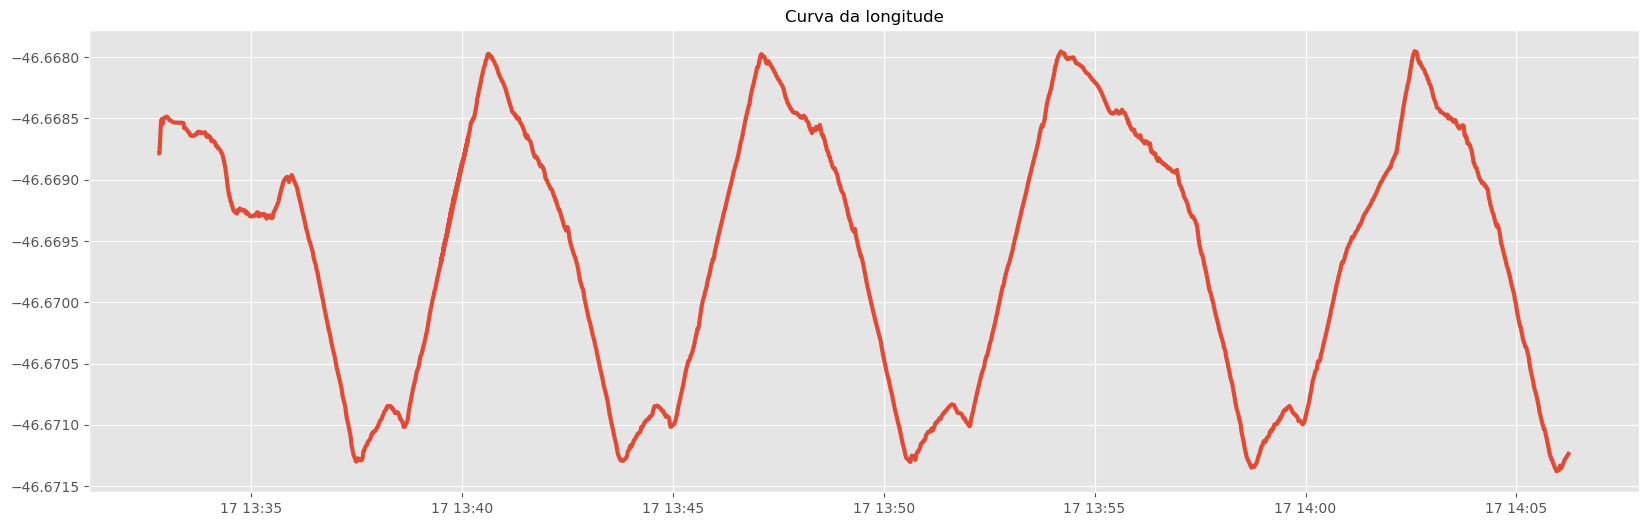

In [22]:
## plot data
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df.created_at_local, df.longitude)
ax.set_title('Curva da longitude') 


In [23]:
from findpeaks import findpeaks

fp = findpeaks(whitelist=['peak', 'valley'])
results = fp.fit(df.longitude)

df['valley'] = results['df'].valley.to_list()
df['peaks'] = results['df'].peak.to_list()
df[['created_at_local', 'longitude', 'turn', 'peaks', 'valley']]

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


created_at_local  longitude  turn  peaks  valley
27121 2024-08-17 13:32:49.792 -46.668785     1  False    True
27122 2024-08-17 13:32:49.800 -46.668785     1  False   False
27123 2024-08-17 13:32:52.150 -46.668524     1  False   False
27124 2024-08-17 13:32:53.076 -46.668506     1  False   False
27125 2024-08-17 13:32:54.038 -46.668548     1  False   False
27126 2024-08-17 13:32:55.028 -46.668515     1  False   False
27127 2024-08-17 13:32:56.047 -46.668499     1  False   False
27128 2024-08-17 13:32:57.041 -46.668494     1  False   False
27129 2024-08-17 13:32:58.032 -46.668492     1  False   False
27130 2024-08-17 13:32:59.041 -46.668489     1  False   False
27131 2024-08-17 13:33:00.034 -46.668485     1  False   False
27132 2024-08-17 13:33:01.040 -46.668487     1  False   False
27133 2024-08-17 13:33:02.038 -46.668497     1  False   False
27134 2024-08-17 13:33:03.101 -46.668506     1  False   False
27135 2024-08-17 13:33:04.035 -46.668514     1  False   False
27136 2024-08-17 13:33:05.072 -46.668514     1  False   False
27137 2024-08-17 13:33:06.051 -46.668519     1  False   False
27138 2024-08-17 13:33:07.033 -46.668522     1  False   False
27139 2024-08-17 13:33:08.033 -46.668526     1  False   False
27140 2024-08-17 13:33:09.033 -46.668530     1  False   False
27141 2024-08-17 13:33:10.031 -46.668532     1  False   False
27142 2024-08-17 13:33:11.032 -46.668533     1  False   False
27143 2024-08-17 13:33:12.029 -46.668534     1  False   False
27144 2024-08-17 13:33:13.043 -46.668535     1  False   False
27145 2024-08-17 13:33:14.041 -46.668535     1  False   False
27146 2024-08-17 13:33:15.035 -46.668535     1  False   False
27147 2024-08-17 13:33:16.036 -46.668535     1  False   False
27148 2024-08-17 13:33:17.038 -46.668535     1  False   False
27149 2024-08-17 13:33:18.050 -46.668535     1  False   False
27150 2024-08-17 13:33:19.038 -46.668535     1  False   False
27151 2024-08-17 13:33:20.046 -46.668535     1  False   False
27152 2024-08-17 13:33:21.037 -46.668536     1  False   False
27153 2024-08-17 13:33:22.040 -46.668537     1  False   False
27154 2024-08-17 13:33:23.041 -46.668536     1  False   False
27155 2024-08-17 13:33:24.036 -46.668538     1  False   False
27156 2024-08-17 13:33:25.046 -46.668580     1  False   False
27157 2024-08-17 13:33:26.043 -46.668581     1  False   False
27158 2024-08-17 13:33:27.042 -46.668582     1  False   False
27159 2024-08-17 13:33:28.040 -46.668585     1  False   False
27160 2024-08-17 13:33:29.046 -46.668596     1  False   False
27161 2024-08-17 13:33:30.046 -46.668606     1  False   False
27162 2024-08-17 13:33:31.044 -46.668611     1  False   False
27163 2024-08-17 13:33:32.040 -46.668614     1  False   False
27164 2024-08-17 13:33:33.053 -46.668631     1  False   False
27165 2024-08-17 13:33:34.048 -46.668638     1  False   False
27166 2024-08-17 13:33:35.041 -46.668637     1  False   False
27167 2024-08-17 13:33:36.037 -46.668643     1  False   False
27168 2024-08-17 13:33:37.054 -46.668641     1  False   False
27169 2024-08-17 13:33:38.044 -46.668642     1  False   False
27170 2024-08-17 13:33:39.040 -46.668641     1  False   False
27171 2024-08-17 13:33:40.044 -46.668637     1  False   False
27172 2024-08-17 13:33:41.038 -46.668632     1  False   False
27173 2024-08-17 13:33:42.055 -46.668631     1  False   False
27174 2024-08-17 13:33:43.045 -46.668617     1  False   False
27175 2024-08-17 13:33:44.044 -46.668620     1  False   False
27176 2024-08-17 13:33:45.045 -46.668610     1  False   False
27177 2024-08-17 13:33:46.050 -46.668608     1  False   False
27178 2024-08-17 13:33:47.042 -46.668611     1  False   False
27179 2024-08-17 13:33:48.035 -46.668617     1  False   False
27180 2024-08-17 13:33:49.040 -46.668621     1  False   False
27181 2024-08-17 13:33:50.045 -46.668616     1  False   False
27182 2024-08-17 13:33:51.042 -46.668617     1  False   False
27183 2024-08-17 13:33:52.039 -46.668615     1  False   False
27184 2024-08-17 13:33:53.041 -46.668621     

In [24]:
zip(df.loc[df.peaks==True][['created_at_local', 'longitude']])

In [25]:
df.loc[df.peaks==True][['created_at_local', 'longitude']]

created_at_local  longitude
27629 2024-08-17 13:40:38.057 -46.667973
28017 2024-08-17 13:47:06.040 -46.667975
28443 2024-08-17 13:54:12.054 -46.667953
28946 2024-08-17 14:02:35.047 -46.667952

Text(0.5, 1.0, 'Peaks')

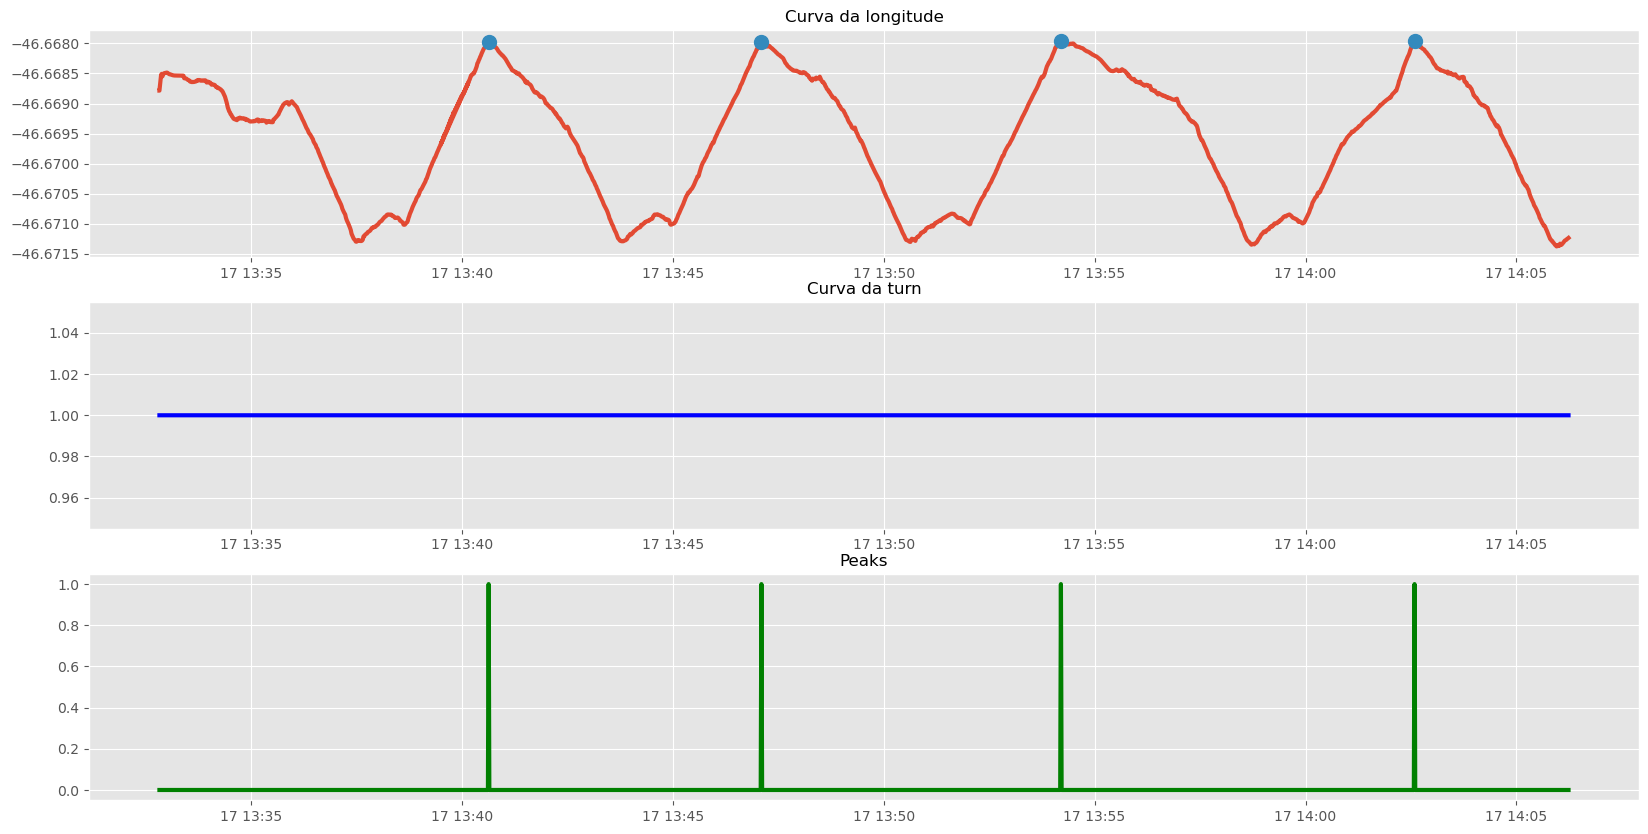

In [26]:
## plot data
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(df.created_at_local, df.longitude)
ax[0].set_title('Curva da longitude') 
a = df.loc[df.peaks==True].created_at_local.to_list()
b = df.loc[df.peaks==True].longitude.to_list()
for s, d in zip(a,b):
    ax[0].annotate("peak", xy = (d,s ))
ax[0].plot_date(a, b)

ax[1].plot(df.created_at_local, df.turn, color='b')
ax[1].set_title('Curva da turn')

ax[2].plot(df.created_at_local, df.peaks, color='g')
# ax[2].plot(df.created_at_local, df.valley, color='b')
ax[2].set_title('Peaks')